In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import numpy.matlib
import pandas as pd
import numpy.linalg as la
%matplotlib inline

In [25]:
df = pd.read_csv('breast-cancer-wisconsin.data.csv',header=None)
df

,0,1,2,3,4,5,6,7,8,9,10
0,1000025,5,1,1,1,2,1,3,1,1,2
1,1002945,5,4,4,5,7,10,3,2,1,2
2,1015425,3,1,1,1,2,2,3,1,1,2
3,1016277,6,8,8,1,3,4,3,7,1,2
4,1017023,4,1,1,3,2,1,3,1,1,2
...,...,...,...,...,...,...,...,...,...,...,...
694,776715,3,1,1,1,3,2,1,1,1,2
695,841769,2,1,1,1,2,1,1,1,1,2
696,888820,5,10,10,3,7,3,8,10,2,4
697,897471,4,8,6,4,3,4,10,6,1,4


In [9]:
df.isnull().any().any()

False

In [26]:
df.rename(columns={0:'id',1:'clump thickness',2:'uniformity of cellsize',
           3:'uniformity of cell shape',4:'marginal adhesion', 
           5:'single epithelial cell size',6:'bare nuclei', 
           7:'bland chromatin',8:'normal nucleoli',9:'mitosis',10:'class'},inplace=True)

'''Sample code number: id number
Clump Thickness: 1 - 10
Uniformity of Cell Size: 1 - 10
Uniformity of Cell Shape: 1 - 10
Marginal Adhesion: 1 - 10
Single Epithelial Cell Size: 1 - 10
Bare Nuclei: 1 - 10
Bland Chromatin: 1 - 10
Normal Nucleoli: 1 - 10
Mitoses: 1 - 10
Class: (2 for benign, 4 for malignant)'''


'Sample code number: id number\nClump Thickness: 1 - 10\nUniformity of Cell Size: 1 - 10\nUniformity of Cell Shape: 1 - 10\nMarginal Adhesion: 1 - 10\nSingle Epithelial Cell Size: 1 - 10\nBare Nuclei: 1 - 10\nBland Chromatin: 1 - 10\nNormal Nucleoli: 1 - 10\nMitoses: 1 - 10\nClass: (2 for benign, 4 for malignant)'

no null values

In [10]:
df['class'] = df['class'].replace(to_replace = 2, value = 0) #benign
df['class'] = df['class'].replace(to_replace = 4, value = 1) #malignant

In [11]:
df['bare nuclei'] = df['bare nuclei'].replace(to_replace = '?', value = None)

In [12]:
df['bare nuclei'] = df['bare nuclei'].astype('int64')

In [13]:
df = df.drop(columns=['id'])
df

,clump thickness,uniformity of cellsize,uniformity of cell shape,marginal adhesion,single epithelial cell size,bare nuclei,bland chromatin,normal nucleoli,mitosis,class
0,5,1,1,1,2,1,3,1,1,0
1,5,4,4,5,7,10,3,2,1,0
2,3,1,1,1,2,2,3,1,1,0
3,6,8,8,1,3,4,3,7,1,0
4,4,1,1,3,2,1,3,1,1,0
...,...,...,...,...,...,...,...,...,...,...
694,3,1,1,1,3,2,1,1,1,0
695,2,1,1,1,2,1,1,1,1,0
696,5,10,10,3,7,3,8,10,2,1
697,4,8,6,4,3,4,10,6,1,1


# K-Means

In [14]:
def plotCurrent(X, Rnk, Kmus):
    N, D = np.shape(X)
    K = np.shape(Kmus)[0]
    InitColorMat = np.matrix([[1, 0, 0], 
                              [0, 1, 0],   
                              [0, 0, 1],
                              [0, 0, 0],
                              [1, 1, 0], 
                              [1, 0, 1], 
                              [0, 1, 1]])
    KColorMat = InitColorMat[0:K]
    colorVec = Rnk.dot(KColorMat)
    muColorVec = np.eye(K).dot(KColorMat)
    plt.scatter(X[:,3], X[:,9], edgecolors=colorVec, marker='o', facecolors='none', alpha=0.3)
    plt.scatter(Kmus[:,0], Kmus[:,1], c=muColorVec, marker='D', s=50);

In [15]:
def calcSqDistances(X, Kmus): #NEED TO CALCULATE MULTIDIMENSIONAL DISTANCE
    N = np.shape(X)[0]
    K = Kmus.shape[0]
    D = [] #initialize to be NxK shape np.zeros()
    for point in X:
        for kpoint in Kmus:
            #D.append([(la.norm(point - kpoint))**2])
            #D.append([(point - kpoint)**2])
            #print(type(point),type(kpoint))
            #print(point, kpoint)
            D.append(np.sqrt(np.sum((point - kpoint)**2)))
    D = np.array(D)
    D = D.reshape((N, K))
                     
    return D

In [16]:
def determineRnk(sqDmat):
    m,n = sqDmat.shape
    for arr in sqDmat:
        index = np.argmin(arr, axis = None, out = None)
        for i in range(n):
            if not i==index:
                arr[i] = 0
        arr[index] = 1
    return sqDmat

In [17]:
def recalcMus(X, Rnk):
    return (np.divide(X.T.dot(Rnk), np.sum(Rnk,axis=0))).T

In [18]:
def runKMeans(K, data):
    X = data.to_numpy()
    N = np.shape(X)[0]
    D = np.shape(X)[1]
    Kmus = np.zeros((K, D))
    rndinds = np.random.permutation(N)
    Kmus = X[rndinds[:K]];
    maxiters = 1000;
    for iter in range(maxiters):
        sqDmat = calcSqDistances(X, Kmus);
        Rnk = determineRnk(sqDmat)
        KmusOld = Kmus
        plotCurrent(X, Rnk, Kmus)
        plt.show()
        Kmus = recalcMus(X, Rnk)
        if sum(abs(KmusOld.flatten() - Kmus.flatten())) < 1e-6:
            break
    plotCurrent(X,Rnk,Kmus)

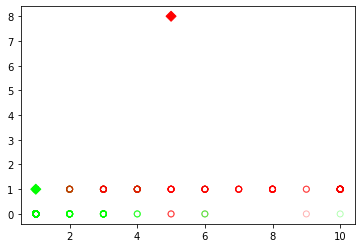

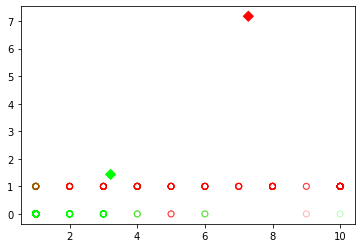

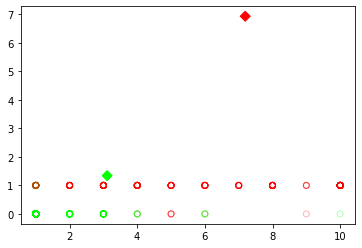

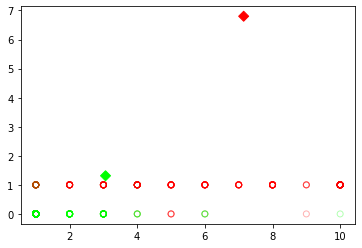

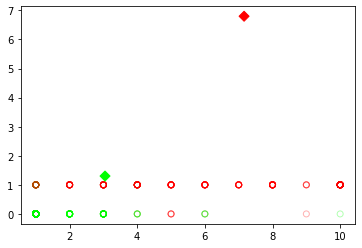

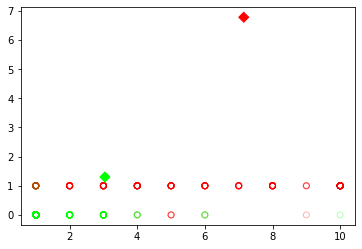

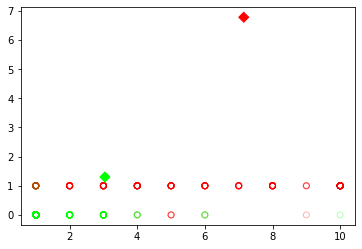

In [19]:
runKMeans(2, df)

In [20]:
from sklearn.cluster import KMeans
clusters = 2
  
kmeans = KMeans(n_clusters = clusters)
kmeans.fit(df)
  
print(kmeans.labels_)

[0 1 0 1 0 1 0 0 0 0 0 0 0 0 1 0 0 0 1 0 1 1 0 0 0 1 0 0 0 0 0 0 1 0 0 0 1
 0 1 1 1 1 1 1 1 0 1 0 0 1 0 0 1 1 1 1 1 0 1 0 1 0 1 0 0 0 0 1 1 0 0 1 0 1
 1 0 0 0 0 0 0 0 0 0 1 1 1 1 0 0 0 0 0 0 0 0 0 0 1 1 1 0 0 0 1 0 1 1 0 1 0
 1 1 1 0 0 0 1 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 0 0 0 0 0 0 0 0 0 1 0 0 0 1 0
 0 1 0 1 1 0 0 1 0 0 0 1 1 0 0 0 0 0 1 1 0 0 0 0 0 1 1 1 0 1 0 1 0 0 0 1 1
 0 1 1 1 0 1 1 0 0 0 0 1 0 0 0 1 1 0 0 0 1 1 0 0 0 1 1 0 1 1 1 0 0 1 0 0 1
 0 1 1 0 1 1 0 1 1 1 0 1 0 0 1 1 1 1 0 0 0 0 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0
 1 1 1 1 1 1 0 1 1 1 0 1 0 1 0 0 0 0 0 0 1 0 0 1 1 1 1 1 0 1 1 0 0 1 1 0 1
 1 0 0 1 1 0 1 0 1 1 0 0 1 0 0 0 1 0 0 1 1 1 0 1 1 0 0 1 0 0 1 0 1 1 1 0 0
 1 1 0 1 0 0 1 1 0 0 0 1 0 0 0 0 1 0 0 1 1 0 0 0 1 1 1 1 1 0 0 0 0 1 1 0 0
 0 0 0 0 0 0 0 0 0 0 0 1 0 0 0 0 1 0 0 0 0 1 0 0 0 0 0 0 0 0 1 0 0 0 0 0 0
 0 0 0 0 0 1 0 1 0 1 0 0 0 0 1 0 0 0 1 0 1 0 0 0 0 0 0 1 1 1 0 0 0 1 0 0 0
 0 0 0 0 0 1 0 0 0 1 0 0 1 1 0 0 0 0 0 0 0 1 1 1 0 0 0 0 0 0 0 0 0 0 0 1 0
 0 1 1 0 0 0 1 1 0 0 1 0 

In [21]:
from sklearn.decomposition import PCA
  
pca = PCA(3)
pca.fit(df)
  
pca_data = pd.DataFrame(pca.transform(df))
  
print(pca_data.head())

          0         1         2
0 -4.450163  0.138269 -1.738765
1  4.812945 -4.861437  0.883325
2 -4.606417 -0.603443  0.029277
3  5.114643  3.467350 -2.026483
4 -4.085787 -0.036483  0.057245


In [22]:
from matplotlib import colors as mcolors
import math
clusters = 2   
''' Generating different colors in ascending order 
                                of their hsv values '''
colors = list(zip(*sorted((
                    tuple(mcolors.rgb_to_hsv(
                          mcolors.to_rgba(color)[:3])), name)
                     for name, color in dict(
                            mcolors.BASE_COLORS, **mcolors.CSS4_COLORS
                                                      ).items())))[1]
   
   
# number of steps to taken generate n(clusters) colors 
skips = math.floor(len(colors[5 : -5])/clusters)
cluster_colors = colors[5 : -5 : skips]

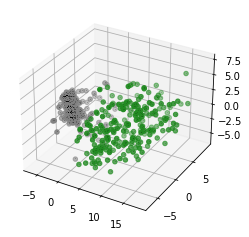

In [23]:
from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
   
fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')
ax.scatter(pca_data[0], pca_data[1], pca_data[2], 
           c = list(map(lambda label : cluster_colors[label],
                                            kmeans.labels_)))
   
str_labels = list(map(lambda label:'% s' % label, kmeans.labels_))
   
list(map(lambda data1, data2, data3, str_label:
        ax.text(data1, data2, data3, s = str_label, size = 0.6,
        zorder = 20, color = 'k'), pca_data[0], pca_data[1],
        pca_data[2], str_labels))
   
plt.show()